# Learn Valid Words
The goal of this notebook is to train a model to discern between valid and invalid word candidates. The trained classifier should be able to take a five-letter sequence of characters and predict if it is a valid word or not.

## Approach
The _valid word attempt_ dataset is trained against several potential classifiers. Confusion matices are generated for each, including precision, recall, f1 and accuracy scores. Based on these scores a classifier is selected and manually tuned. Finally, samples of the predicted data are presented for inspection (false-positives, false-negatives, true-positives, true-negatives).

## Out of Scope
This notebook is intended as a smokescreen to aid in manually evaluating machine learning classifiers for this problem, and to serve as a tool in selecting one that looks promision. Automated bias detection, hyperparameter tuning and deployment (among other things) are not within the scope of what is intended for this notebook to achieve.

## Background on the dataset
The _valid word attempt_ dataset was generated from **Alurdle** games played by a bot on the alurdle game server. The bot generated random sequences of letters and has no way of discernining between a valid and invalid word. To assist in balancing the data, valid words from the dictionary are randomly injected. The resulting dataset provides a labeled mix of valid and invalid words that can be useful for ML training.

In [1]:
# Constants
S3_BUCKET_ML_PATH="s3://ads-datasets/wordle-ml"
S3_BUCKET_PLAYER_PATH="s3://ads-datasets/wordle-player"
S3_FLD_CSV="flat"
S3_FLD_PQT="parquet"
S3_FLD_MODEL="models"

FILENAME_GAMETURNS_CSV = "game-turns.csv"
FILENAME_GAMETURNS_PQT = "game-turns.parquet"
FILENAME_VALIDWORDATTEMPTS_CSV = "valid-word-attempts.csv"
FILENAME_VALIDWORDATTEMPTS_PQT = "valid-word-attempts.parquet"
FILENAME_VALIDWORDATTEMPTS_MODEL = "valid-words-model.pkl"

WORD_LENGTH = 5

In [2]:
# Helper dict to locate files in s3 player bucket
src_dir = {
  S3_FLD_CSV: {
    'folder': S3_FLD_CSV,
    'file': {
      'gameturns': FILENAME_GAMETURNS_CSV,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_CSV,
    }
  },
  S3_FLD_PQT: {
    'folder': S3_FLD_PQT,
    'file': {
      'gameturns': FILENAME_GAMETURNS_PQT,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_PQT,
    }
  },
}

# Helper dict to locate files in s3 ML bucket
out_dir = {
  S3_FLD_MODEL: {
    'folder': S3_FLD_MODEL,
    'file': {
      'validwords': FILENAME_VALIDWORDATTEMPTS_MODEL,
    }
  },
}

## Load and inspect the data

The *validwordattempts* and *gameturns* datasets are available in both CSV and parquet format in an S3 bucket. The *load_raw_data()* function takes care of reading the dataset into a Pandas DataFrame.

We load and inspect each dataset, though we're only interested in *validwordattempts* for now. We inspect the balance of *isValid* labels, noting a 30-70 split between (True / False).

In [3]:
import awswrangler as wr
import os

# Loads the raw data
def load_raw_data(format=S3_FLD_PQT, filename='gameturns'):
  bucket_path = S3_BUCKET_PLAYER_PATH
  fld_format = src_dir[format]['folder']
  file_name = src_dir[format]['file'][filename]

  path = os.path.join(bucket_path, fld_format, file_name)

  return wr.s3.read_parquet(path=path)

In [4]:
# Inspect game turns data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='gameturns')
df.head()

,gameId,turns
0,c7q67hdsi8ns738u2vm0,"[{'guess': 'LEACH', 'isValid': True, 'tryResul..."
1,c7q67klsi8ns738u36dg,"[{'guess': 'ACXNX', 'isValid': False, 'tryResu..."
2,c7q67ktsi8ns738u36vg,"[{'guess': 'ALUZV', 'isValid': False, 'tryResu..."
3,c7q67l5si8ns738u37ag,"[{'guess': 'UBUHK', 'isValid': False, 'tryResu..."
4,c7q67l5si8ns738u37fg,"[{'guess': 'VHERY', 'isValid': False, 'tryResu..."


In [5]:
# Inspect valid word attempt data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')
df.head()

,guess,isValid,gameId
0,LEACH,True,c7q67hdsi8ns738u2vm0
1,BNVUX,False,c7q67hdsi8ns738u2vm0
2,NHBLJ,False,c7q67hdsi8ns738u2vm0
3,JZJKV,False,c7q67hdsi8ns738u2vm0
4,HCPXK,False,c7q67hdsi8ns738u2vm0


In [6]:
import pandas as pd

# Inspect the imbalance of isValid rows
df_label_counts = pd.DataFrame(df['isValid'].value_counts(normalize=True))
df_label_counts

,isValid
False,0.702346
True,0.297654


## Prepare the data for training

Now available in a DataFrame, the data needs to be prepared and split into training and test sets. We start by using *prepare_valid_word_data()* to break each word into individual characters and split the set, holding back 10% of the data for testing. 

The *train_classifier()* function one-hot encodes the letters into numpy arrays so that each can be used as a separate feature. The transformed X and y training data is then fit by the classifier, which is passed as a parameter allowing the training function to be reused with a variety of classifiers.

The *predict_from_classifier()* function uses the same one-hot encoder to transform input for inferencing using the trained classifier, which is passed in as a parameter.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

letter_cols = [f'l{n}' for n in range(WORD_LENGTH)]

# Prepare valid words dataset
def prepare_valid_word_data(format=S3_FLD_PQT, filename='validwordattempts', test_size=0.1):
  df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')

  # Split each guess word to letters in individual columns
  df = df.join(
    pd.DataFrame(
      [list(w) for w in df['guess']], 
      columns=letter_cols)
    )
  
  # Training-testing split
  y = df['isValid'].astype(int)
  X = df.drop(['isValid'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

  return X_train, X_test, y_train, y_test


In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight

# Train a classifier
def train_classifier(X_train, y_train, clf=LogisticRegression()):
  global ohe 

  # One-hot encode the letters
  ohe = OneHotEncoder(handle_unknown='error')
  X_train_ohe = ohe.fit_transform(X_train[letter_cols])

  # Fit the training data
  clf.fit(X_train_ohe, y_train.to_numpy())
  
  return clf


# Predict from a trained classifier
def predict_from_classifier(X, clf):
  global ohe
  X_ohe = ohe.transform(X[letter_cols])

  return clf.predict(X_ohe)


## Visualizing the results

We will evaluate the accuracy of each model with the help of a confusion matrix, together with a breakdown of precision, recall and f1 scores for each label. The *plot_confusion_matrix()* calculates the scores for each model's predictions and prepares the plots.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Plot results as a confusion matrix
def plot_confusion_matrix(name, prediction, y_test):
  accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
  f1 = f1_score(y_true=y_test, y_pred=prediction)
  precision = precision_score(y_true=y_test, y_pred=prediction)
  recall = recall_score(y_true=y_test, y_pred=prediction)

  cf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)

  group_names = ['True Neg','False Neg','False Pos','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  summary_text = classification_report(y_true=y_test, y_pred=prediction)

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  figsize = plt.rcParams.get('figure.figsize')
  plt.figure(figsize=figsize)
  sns.heatmap(
    cf_matrix/np.sum(cf_matrix), 
    annot=labels,
    fmt='', 
    cmap='Blues')
  plt.xlabel(name + '\n' + summary_text)

  return classification_report(y_true=y_test, y_pred=prediction)

  

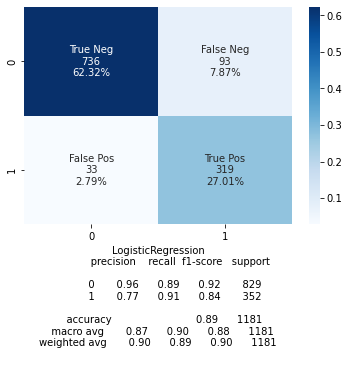

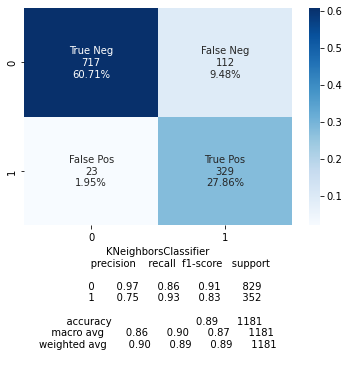

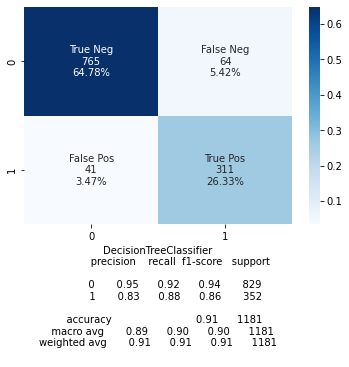

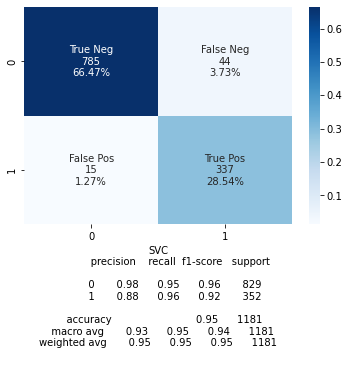

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Try a few different classifiers
clf_dict = {
  'LogisticRegression': LogisticRegression(class_weight='balanced'),
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
  'SVC': SVC(class_weight='balanced'),
}

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
for name in clf_dict:
  clf = clf_dict[name]
  model = train_classifier(X_train, y_train, clf)
  prediction = predict_from_classifier(X_test, model)
  plot_confusion_matrix(name, prediction, y_test)


## Model selection, tuning and output

Between the models evaluated above, SVC stands out as the strongest performer. 

We use the next cell to run it again, manually adjusting its hyperparameters to further improve its performance. We observe that using the poly kernel provides higher f1 scores with a smaller spread between classes and a higher overall accuracy.

Having retrained the classifier, we inspect samples of the predictions that it has produced. Noting that the precision score for the *True* class is low compared with the precision and recall scores of the other classes, we are especially interested in reviewing the false positives and false negatives.

'              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97       829\n           1       0.93      0.95      0.94       352\n\n    accuracy                           0.96      1181\n   macro avg       0.95      0.96      0.96      1181\nweighted avg       0.96      0.96      0.96      1181\n'

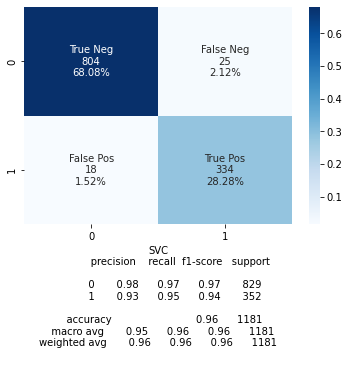

In [11]:
from sklearn.svm import SVC

# Use best performing classifier
clf = SVC(kernel='poly', degree=3, class_weight='balanced')

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
model = train_classifier(X_train, y_train, clf)
prediction = predict_from_classifier(X_test, model)
plot_confusion_matrix(name, prediction, y_test)


In [12]:
# Inspect the test predictions
df_test_pred = X_test.join(y_test)
df_test_pred['prediction'] = prediction == y_test

# False negatives
df_test_pred_fn = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 0)]
# False positives
df_test_pred_fp = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 1)]
# True negatives
df_test_pred_tn = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 0)]
# True positives
df_test_pred_tp = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 1)]


In [13]:
df_test_pred_fp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
7204,EQUIP,c7q6ti8qcq3c73e1fo3g,E,Q,U,I,P,1,False
11619,RHEIN,c7q6tn0qcq3c73e1ftu0,R,H,E,I,N,1,False
9668,DAKAR,c7q6tkoqcq3c73e1frbg,D,A,K,A,R,1,False
6496,SQUAW,c7q6thgqcq3c73e1fn5g,S,Q,U,A,W,1,False
535,EJECT,c7q6f25si8ns738u3mtg,E,J,E,C,T,1,False
8530,GAUZE,c7q6tjgqcq3c73e1fprg,G,A,U,Z,E,1,False
7504,DILDO,c7q6tigqcq3c73e1fog0,D,I,L,D,O,1,False
658,SQUAW,c7q6f25si8ns738u3n30,S,Q,U,A,W,1,False
324,ILIAD,c7q6f1tsi8ns738u3mk0,I,L,I,A,D,1,False
6283,ALTAR,c7q6th8qcq3c73e1fmsg,A,L,T,A,R,1,False


In [14]:
df_test_pred_fn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
9775,DEYVE,c7q6tl0qcq3c73e1frg0,D,E,Y,V,E,0,False
4424,DCEER,c7q6tf8qcq3c73e1fkdg,D,C,E,E,R,0,False
3106,WRATO,c7q6tdoqcq3c73e1fil0,W,R,A,T,O,0,False
9953,APISZ,c7q6tl8qcq3c73e1frng,A,P,I,S,Z,0,False
6105,ABPON,c7q6th0qcq3c73e1fml0,A,B,P,O,N,0,False
3634,VILYL,c7q6te8qcq3c73e1fjbg,V,I,L,Y,L,0,False
11112,DABIA,c7q6tmgqcq3c73e1ft8g,D,A,B,I,A,0,False
4022,TRIEG,c7q6teoqcq3c73e1fjs0,T,R,I,E,G,0,False
9084,UIGKS,c7q6tk8qcq3c73e1fqj0,U,I,G,K,S,0,False
6344,REDNN,c7q6th8qcq3c73e1fmv0,R,E,D,N,N,0,False


In [15]:
df_test_pred_tp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
4316,DOZED,c7q6tf0qcq3c73e1fk90,D,O,Z,E,D,1,True
529,DEEMS,c7q6f1tsi8ns738u3mt0,D,E,E,M,S,1,True
1622,SITAR,c7q6tc8qcq3c73e1fgmg,S,I,T,A,R,1,True
6215,RESIT,c7q6th8qcq3c73e1fmpg,R,E,S,I,T,1,True
6669,DECRY,c7q6thgqcq3c73e1fncg,D,E,C,R,Y,1,True
...,...,...,...,...,...,...,...,...,...
10047,STARK,c7q6tl8qcq3c73e1frrg,S,T,A,R,K,1,True
852,LASSO,c7q6f25si8ns738u3nb0,L,A,S,S,O,1,True
5554,FLAKE,c7q6tggqcq3c73e1flu0,F,L,A,K,E,1,True
8129,VACUA,c7q6tj8qcq3c73e1fpa0,V,A,C,U,A,1,True


In [16]:
df_test_pred_tn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
7451,SRXLQ,c7q6tigqcq3c73e1foe0,S,R,X,L,Q,0,True
9559,QNZQY,c7q6tkoqcq3c73e1fr70,Q,N,Z,Q,Y,0,True
4617,JMOCD,c7q6tfgqcq3c73e1fkm0,J,M,O,C,D,0,True
4666,LJTPF,c7q6tfgqcq3c73e1fko0,L,J,T,P,F,0,True
1876,KTQSI,c7q6tcgqcq3c73e1fh10,K,T,Q,S,I,0,True
...,...,...,...,...,...,...,...,...,...
5319,JYTMA,c7q6tg8qcq3c73e1fljg,J,Y,T,M,A,0,True
10142,MZDPN,c7q6tl8qcq3c73e1frvg,M,Z,D,P,N,0,True
11206,LYFED,c7q6tmgqcq3c73e1ftcg,L,Y,F,E,D,0,True
7657,EJXBX,c7q6tioqcq3c73e1fomg,E,J,X,B,X,0,True


## Persist the model

Save the model in S3 for later use by the API. We use the first cell to save it and the second and third cells to reload the model and generate a prediction from the same test data used above. The confusion matrices should match (otherwise the model was not properly saved and reloaded).

In [17]:
import awswrangler as wr
import joblib
import os
import tempfile

# Save the model to s3
with tempfile.TemporaryFile() as tmp:
  joblib.dump(model, tmp)

  bucket_path = S3_BUCKET_ML_PATH
  fld_format = out_dir[S3_FLD_MODEL]['folder']
  file_name = out_dir[S3_FLD_MODEL]['file']['validwords']
  path = os.path.join(bucket_path, fld_format, file_name)

  print(f"Writing model file to {path}...")
  tmp.seek(0)
  wr.s3.upload(tmp, path)

Writing model file to s3://ads-datasets/wordle-ml/models/valid-words-model.pkl...


In [18]:
import awswrangler as wr
import joblib
import os

# Load the saved model from s3
model = None
with tempfile.TemporaryFile() as tmp:
  bucket_path = S3_BUCKET_ML_PATH
  fld_format = out_dir[S3_FLD_MODEL]['folder']
  file_name = out_dir[S3_FLD_MODEL]['file']['validwords']
  path = os.path.join(bucket_path, fld_format, file_name)

  print(f"Loading model file from {path}...")
  wr.s3.download(path, tmp)
  tmp.seek(0)
  model = joblib.load(tmp)
  

Loading model file from s3://ads-datasets/wordle-ml/models/valid-words-model.pkl...


'              precision    recall  f1-score   support\n\n           0       0.98      0.97      0.97       829\n           1       0.93      0.95      0.94       352\n\n    accuracy                           0.96      1181\n   macro avg       0.95      0.96      0.96      1181\nweighted avg       0.96      0.96      0.96      1181\n'

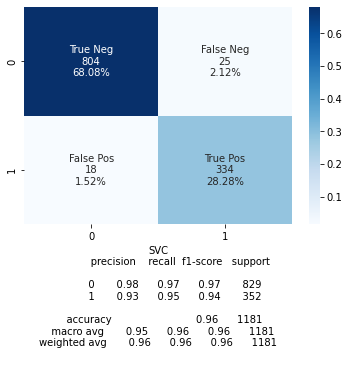

In [19]:
# Attempt predictions again (these should match )
prediction = predict_from_classifier(X_test, model)
plot_confusion_matrix(name, prediction, y_test)
